# Activity models

In [177]:
using Pkg, Revise
Pkg.activate("..")
using Clapeyron, PyCall
import PyPlot; const plt = PyPlot
# ternary = pyimport("ternary")

  Activating project at `~/Library/CloudStorage/OneDrive-ImperialCollegeLondon/University/UROP/SAFT_codes/Clapeyron`


PyPlot

In [253]:
revise(Clapeyron)

┌ Warning: Replacing docs for `Clapeyron.arbitraryparam :: Tuple{Any}` in module `Clapeyron`
└ @ Base.Docs docs/Docs.jl:243
┌ Warning: Replacing docs for `Clapeyron.@groups :: Tuple{}` in module `Clapeyron`
└ @ Base.Docs docs/Docs.jl:243
┌ Warning: Replacing docs for `Clapeyron.@groups :: Tuple{Any}` in module `Clapeyron`
└ @ Base.Docs docs/Docs.jl:243
┌ Warning: Replacing docs for `Clapeyron.@sites :: Tuple{Any}` in module `Clapeyron`
└ @ Base.Docs docs/Docs.jl:243
┌ Warning: Replacing docs for `Clapeyron.@f :: Tuple{Any, Vararg{Any}}` in module `Clapeyron`
└ @ Base.Docs docs/Docs.jl:243
┌ Warning: Replacing docs for `Clapeyron.default_locations :: Tuple{EoSModel}` in module `Clapeyron`
└ @ Base.Docs docs/Docs.jl:243
┌ Warning: Replacing docs for `Clapeyron.default_gclocations :: Tuple{EoSModel}` in module `Clapeyron`
└ @ Base.Docs docs/Docs.jl:243
┌ Warning: Replacing docs for `Clapeyron.default_ignore_missing_singleparams :: Tuple{Any}` in module `Clapeyron`
└ @ Base.Docs docs/Docs.

┌ Warning: Replacing docs for `Clapeyron.init_electrolyte_model :: Union{Tuple{EoSModel, Any, Any}, Tuple{EoSModel, Any, Any, Any}, Tuple{EoSModel, Vararg{Any, 4}}}` in module `Clapeyron`
└ @ Base.Docs docs/Docs.jl:243
┌ Warning: Replacing docs for `Clapeyron.@registermodel :: Tuple{Any}` in module `Clapeyron`
└ @ Base.Docs docs/Docs.jl:243


┌ Warning: Replacing docs for `Clapeyron.pharmaPCSAFT :: Union{}` in module `Clapeyron`
└ @ Base.Docs docs/Docs.jl:243
┌ Warning: Replacing docs for `Clapeyron.DH :: Union{}` in module `Clapeyron`
└ @ Base.Docs docs/Docs.jl:243


true

In this notebook, we will be giving examples on how to use activity models within `Clapeyron.jl`. We include examples of how one can customise their activity model and how it can be used in tangent with a cubic equation of state.

## MIAC of NaCl in water

Activity models cannot be used on their own; they provide us with an activity for a species in the mixture but, to obtain VLE properties from this, we need a saturation pressure. This can be obtained from any of the equations of state provided in `Clapeyron.jl` using the optional argument `puremodel`. We use the water + ethanol mixture as an example:

In [276]:
rsp = ConstRSP(["carbon dioxide"],["1-butyl-3-methylimidazolium","hexafluorophosphate"]; value = 1.)

model = ESElectrolyte(["carbon dioxide"],["1-butyl-3-methylimidazolium","hexafluorophosphate"];
                neutralmodel = PCSAFT,
                ionmodel = DH,
                RSPmodel = rsp)
# model.neutralmodel.params.epsilon["sodium"] = 0
# model.neutralmodel.params.epsilon["chloride"] = 0

ESElectrolyte{BasicIdeal, PCSAFT{BasicIdeal, Float64}, DH{ConstRSP}} with 3 components:
 "carbon dioxide"
 "1-butyl-3-methylimidazolium"
 "hexafluorophosphate"

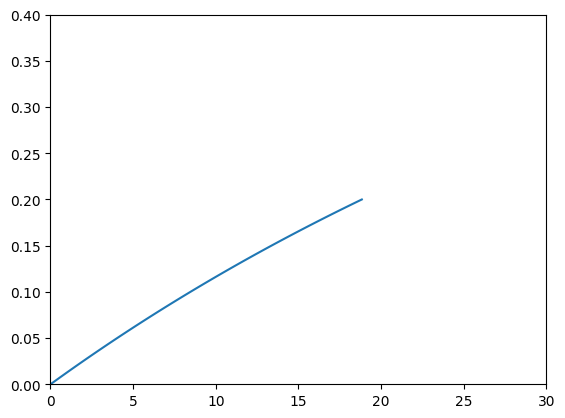

In [277]:
method = FugBubblePressure(nonvolatiles=["1-butyl-3-methylimidazolium","hexafluorophosphate"])

T = 323.
x = LinRange(1e-10,0.2,100)
X = zeros(100,3)
X[:,1] = x
X[:,2:3] .= 1 .-x

X ./= sum(X,dims=2)
p = zeros(100)

for i in 1:100
    bub = bubble_pressure(model,T,X[i,:],method)
    p[i] = bub[1]
end

plt.clf()
plt.plot(p./1e5,x)
plt.xlim(0,30)
plt.ylim(0,0.4)
display(plt.gcf())

In [270]:
p

100-element Vector{Float64}:
      0.001164953333060839
  23583.938156272852
  47267.43401000444
  71051.25514346069
  94936.17718889804
 118922.98515012728
 143012.47356266784
 167205.4466575121
 191502.7185285172
 215905.11330376388
      ⋮
      2.682404026214941e6
      2.7199963387769195e6
      2.75783264699178e6
      2.7959162098130137e6
      2.8342503592175897e6
      2.872838502578346e6
      2.9116841251389403e6
      2.9507907925953707e6
      2.9901621537903952e6

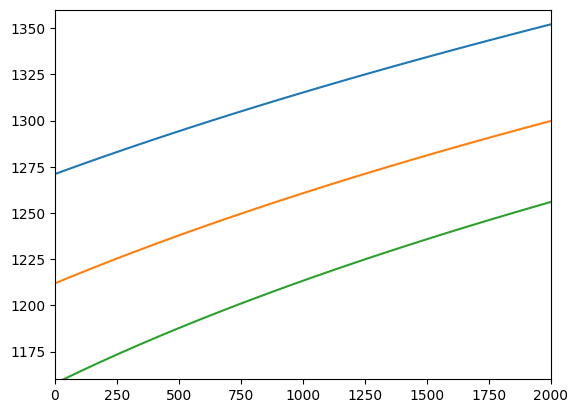

In [259]:
p = LinRange(1e5,2000e5,100)

ρ = zeros(100,3)

ρ[:,1] .= mass_density.(model,p,313.2,Ref([0.5,0.5]))
ρ[:,2] .= mass_density.(model,p,392.9,Ref([0.5,0.5]))
ρ[:,3] .= mass_density.(model,p,472.4,Ref([0.5,0.5]))

plt.clf()
plt.plot(p./1e5,ρ)
plt.ylim(1160,1360)
plt.xlim(0,2000)
display(plt.gcf())

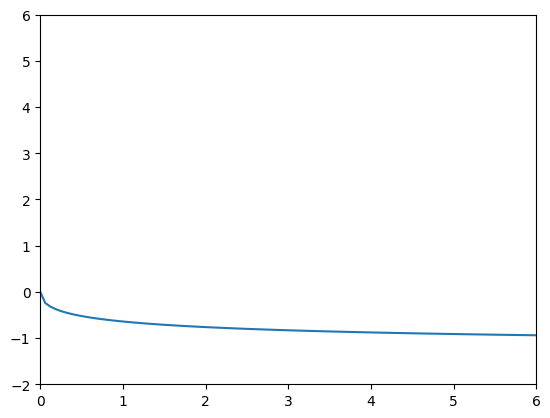

In [139]:
# model.ionmodel.params.sigma["sodium"] = 1.02*2*1e-10
# model.ionmodel.params.sigma["chloride"] = 1.81*2*1e-10

salt = [("KBr",["potassium"=>1,"bromide"=>1])]
V = 1.79997422583824e-05
T = 298.
m = LinRange(1e-30,6,100)
z = molality_to_composition.(model,Ref(salt),m)

a = Clapeyron.VT_chemical_potential_res.(model.ionmodel,V,T,z)
a = [a[i][2] for i in 1:100]/8.314/298.
a .-= a[1]

plt.clf()
plt.plot(m,a)
plt.xlim(0,6)
plt.ylim(-2,6)
# plt.ylim(-1.2,1.5)

display(plt.gcf())

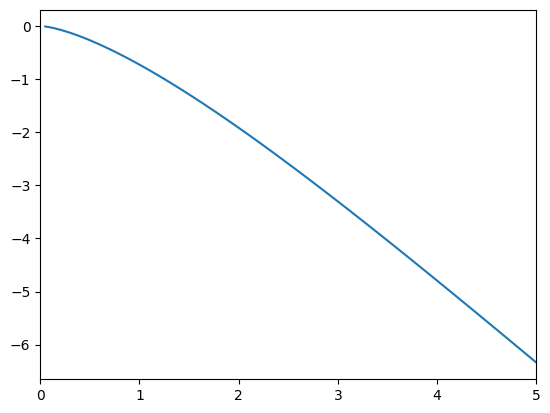

In [90]:
model.ionmodel.params.sigma["sodium"] = 1.02*2*1e-10
model.ionmodel.params.sigma["chloride"] = 1.81*2*1e-10

salt = [("NaCl",["sodium"=>1,"chloride"=>1])]
V = 2.8e-3
T = 298.15
m = LinRange(0,5,100)
z = molality_to_composition.(model,Ref(salt),m)

a = Clapeyron.a_res.(model.ionmodel,V,T,z)./V


plt.clf()
plt.plot(m,a)
plt.xlim(0,5)

display(plt.gcf())

In [171]:
model.neutralmodel.params.epsilon

3×3 PairParam{Float64}(["water08", "potassium", "bromide"]) with values:
 353.945  266.062  259.325
 266.062    0.0    194.936
 259.325  194.936    0.0

In [169]:
model.ionmodel.params.sigma

SingleParam{Float64}("sigma") with 3 components:
 "water08" => 2.7927e-10
 "potassium" => 3.3417e-10
 "bromide" => 3.0707e-10

In [230]:
salts = [("NaCl",["sodium"=>1,"chloride"=>1])]
m = LinRange(1e-5,4,100)
z = molality_to_composition.(model, Ref(salts), m)

p = zeros(100)
vl = zeros(100)
γ = zeros(100)
y0 = nothing
vol0 = nothing
p0 = nothing
for i in 1:length(z)
    bub = bubble_pressure(model, 298.15, z[i], FugBubblePressure(nonvolatiles=["potassium","bromide"]))
    p[i] = bub[1]
    vl[i] = bub[2]
    vol0 = (bub[2], bub[3])
    γ[i] = osmotic_coefficient(model,salts,1e5,298.15,m[i])[1]
end


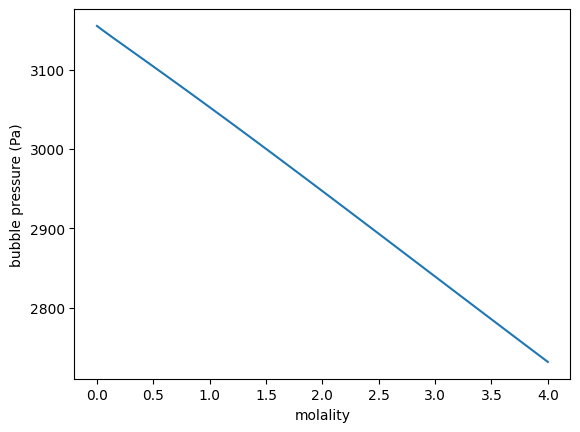

In [166]:
plt.clf()
plt.plot(m,p)
plt.xlabel("molality")
plt.ylabel("bubble pressure (Pa)")
display(plt.gcf())

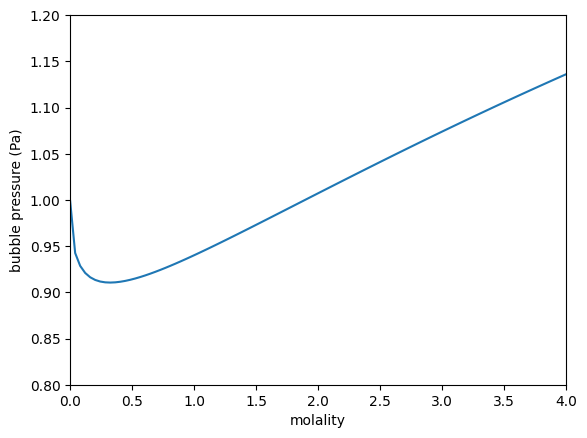

In [231]:
plt.clf()
plt.plot(m,γ)
plt.xlabel("molality")
plt.ylabel("bubble pressure (Pa)")
plt.ylim(0.8,1.2)
plt.xlim(0,4)
display(plt.gcf())

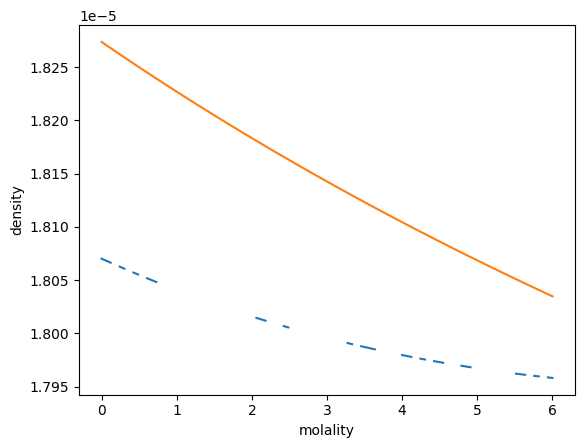

In [64]:
Mw = model.neutralmodel.params.Mw.values
mass = [sum(z[i].*Mw*1e-3) for i in 1:100]
vlb = [Clapeyron.lb_volume(model,z[i]) for i in 1:100]
plt.clf()
plt.plot(m,vl)
plt.plot(m,vlb.+1e-5)

plt.xlabel("molality")
plt.ylabel("density")
# plt.ylim(1000,1200)
display(plt.gcf())

## Flash

In [508]:
revise(Clapeyron)

┌ Warning: Replacing docs for `Clapeyron.pharmaPCSAFT :: Union{}` in module `Clapeyron`
└ @ Base.Docs docs/Docs.jl:243


true

In [702]:
model = ESElectrolyte(["water08","acetonitrile"],["sodium","chloride"];
            neutralmodel=pharmaPCSAFT,
            ionmodel=DH,
            RSPmodel=WAvgRSP)
model.neutralmodel.params.epsilon["sodium","sodium"] = 0
model.neutralmodel.params.epsilon["chloride","chloride"] = 0
model.neutralmodel.params.k["acetonitrile","sodium"] = 0.4
model.neutralmodel.params.k["acetonitrile","chloride"] = 0.4
model.neutralmodel.params.segment

SingleParam{Float64}("segment") with 4 components:
 "water08" => 1.2046817736
 "acetonitrile" => 2.329
 "sodium" => 1.0
 "chloride" => 1.0

In [571]:
model = ESElectrolyte(["water08","PEG200"],["sodium","chloride"];
            neutralmodel=pharmaPCSAFT,
            ionmodel=DH,
            RSPmodel=WAvgRSP)
model.neutralmodel.params.epsilon["sodium","sodium"] = 0
model.neutralmodel.params.epsilon["chloride","chloride"] = 0
model.neutralmodel.params.k["PEG200","sodium"] = 0.
model.neutralmodel.params.k["PEG200","chloride"] = 0.
model.neutralmodel.params.k["PEG200","water08"] = 0.
model.neutralmodel.params.kT["PEG200","water08"] = 0.


0.0

In [688]:
model = SAFTgammaEMie([("water",["H2O"=>1]),("PEG200",["CH2OH"=>2,"CH2OE"=>6,"cO"=>3])],[("sodium",["Na+"=>1]),("chloride",["Cl-"=>1])])
model = SAFTgammaEMie([("water",["H2O"=>1]),("ethanol",["CH2OH"=>1,"CH3"=>1])],[("sodium",["Na+"=>1]),("chloride",["Cl-"=>1])])

model.neutralmodel.params.epsilon["CH2OH","Na+"] = 500.
model.neutralmodel.params.epsilon["CH2OH","Cl-"] = 90.
# model.neutralmodel.params.epsilon["cO","Na+"] = 10.
# model.neutralmodel.params.epsilon["cO","Cl-"] = 10.

90.0

In [705]:
salt = [("NaCl",["sodium"=>1,"chloride"=>1])]
m = 6
w0 = [0.8,0.2]
z0 = w0./[18.01,40]
z0 ./= sum(z0)
K0 = [2e0,0.5e-1,1e3,1e3]

z = molality_to_composition(model,salt,m,z0)
(x,n,G) = tp_flash(model,1e5,298.15,z,MichelsenTPFlash(equilibrium=:lle,K0=K0))

# μ1 = chemical_potential(model,1e5,298.15,x[1,:];phase=:l)
# μ2 = chemical_potential(model,1e5,298.15,x[2,:];phase=:l)
# μ2-μ1

([0.7465007287606622 0.04714857255683225 0.10317535063473846 0.10317534804776704; 0.43110175404248413 0.4951542292367116 0.03687199269563737 0.036872024025166865], [0.6895615990368917 0.04355232866091397 0.09530568025432229 0.09530567786467138; 0.032882163073466995 0.03776774731163325 0.002812400704224807 0.0028124030938757143], -7.480691242536461)

In [666]:
z

4-element Vector{Float64}:
 0.41391667793563097
 0.14909278739241427
 0.21849526733597735
 0.21849526733597735

In [692]:
volume(model,1e5,298.15,[0.998,0.001,0.0005,0.0005];phase=:l)

1.8027146304678867e-5

In [694]:
volume(model,1e5,298.15,[0.001,0.998,0.0005,0.0005];phase=:l)

5.745866308613696e-5

In [661]:
Clapeyron.a_res(model.neutralmodel,1.9e-5,298.15,[0.4775902297333341,0.009517280848723999,0.2564462447089709,0.256446244708970])

-4.280474553135346

In [663]:
Clapeyron.a_res(model.neutralmodel,0.0002105546272216393,298.15,[0.04775902295732692,0.9517280845534271,0.00025644624462302265,0.00025644624462302265])

-23.783007098069497

In [647]:
Clapeyron.x0_volume_liquid(model,298.15,[0.001,0.998,0.0005,0.0005])

0.0002105546272216393

In [524]:
salt = [("NaCl",["sodium"=>1,"chloride"=>1])]
m = LinRange(6,0.1,1000)
z0 = [0.5,0.5]
# z0 = w0./[18.01,200]
# z0 ./= sum(z0)
K0 = [1e3,1e-4,1e5,1e5]
Mw = [18.01,200.,23+35.5]

W = zeros(1000,6)
for i in 1:1000
    println(i)
    z = molality_to_composition(model,salt,m[i],z0)

    (x,n,G) = tp_flash(model,1e5,298.15,z,RRTPFlash(equilibrium=:lle,K0=K0))

    w = x[:,1:3].*Mw'
    w ./= sum(w,dims=2)
    W[i,1:3] = w[1,:]
    W[i,4:6] = w[2,:]

    # println(chemical_potential(model,1e5,298.15,x[1,:];phase=:l))
    # println(chemical_potential(model,1e5,298.15,x[2,:];phase=:l))
    K0 = x[1,:]./x[2,:]
    # println(K0)
    z0 = (x[1,1:2]+x[2,1:2])/2
end

1
2


3
4
5
6


7
8
9
10


11
12
13
14


15
16
17
18


19
20
21
22


23
24
25
26


27
28
29
30


31
32
33
34


35
36
37
38


39
40
41
42


43
44
45
46


47
48
49
50


51
52
53
54


55
56
57
58


59
60
61


62
63
64
65


66
67
68


69
70
71


72
73
74
75


76
77
78
79


80
81
82
83


84
85
86
87


88
89
90
91


92
93
94
95


96
97
98


99
100
101


102
103
104
105


106
107
108
109


110
111
112
113


114
115
116
117


118
119
120
121


122
123
124
125


126
127
128
129


130
131
132


133
134
135
136


137
138
139
140


141
142
143
144


145
146
147
148


149
150
151
152


153
154
155
156


157
158
159
160


161
162
163
164


165
166
167


168
169
170
171


172
173
174


175
176
177
178


179
180
181
182


183
184
185
186


187
188
189
190


191
192
193
194


195
196
197
198


199
200
201


202
203
204
205


InterruptException: InterruptException:

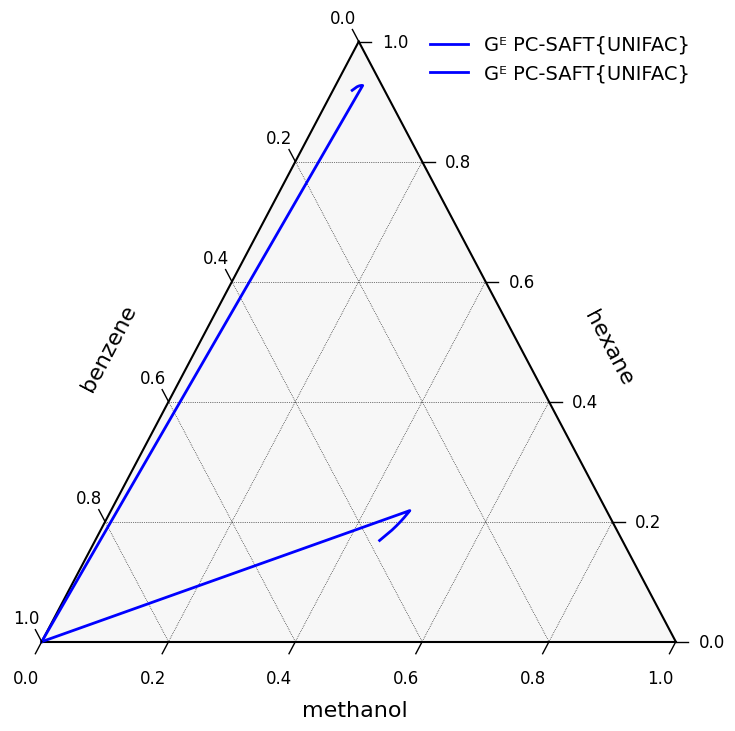

In [525]:
plt.clf()
figure, tax = ternary.figure(scale=1.0)
figure.set_size_inches(9, 9)

tax.boundary()
tax.gridlines(multiple=0.2, color="black")
tax.left_axis_label("benzene", fontsize=16, offset=0.15)
tax.right_axis_label("hexane", fontsize=16, offset=0.15)
tax.bottom_axis_label("methanol", fontsize=16, offset=0.02)

# Plot the data
tax.plot(W[:,1:3], linewidth=2.0,color="b",linestyle="-", label="Gᴱ PC-SAFT{UNIFAC}")
tax.plot(W[:,4:6], linewidth=2.0,color="b",linestyle="-", label="Gᴱ PC-SAFT{UNIFAC}")


tax.ticks(axis="lbr", multiple=0.2, linewidth=1,fontsize=12, tick_formats="%.1f", offset=0.02)

tax.get_axes().axis("off")
tax.clear_matplotlib_ticks()
tax.legend(loc="upper right",frameon=false,fontsize=14)
# tax.savefig("MeOH_Benz_Hx_tern.pdf")
display(plt.gcf())

In [72]:
PEGMw = 1550
model = pharmaPCSAFT(["water08","PEG200"])

model.params.Mw[2] = PEGMw
model.params.segment[2] = model.params.segment[2]/200*PEGMw
Mw = model.params.Mw.values

2-element Vector{Float64}:
   18.015
 1550.0

In [73]:
model.params.epsilon_assoc

AssocParam{Float64}["water08", "PEG200"]) with 2 values:
("water08", "e") >=< ("water08", "H"): 2425.6714
("PEG200", "e") >=< ("PEG200", "H"): 1799.8

In [74]:
bubble_pressure(model,293.15,[1.,0.])

(2333.631492274309, 1.8049697456044e-5, 1.0419734319710137, [1.0, 0.0])

In [75]:
w = LinRange(0.,0.3,100)
x = w/Mw[2]./(w/Mw[2]+(1 .-w)/Mw[1])
X = Clapeyron.FractionVector.(1 .-x)
a = activity_coefficient.(model,2333.631492274309,293.15,X;phase=:l).*(1 .-x)
a = [a[i][1] for i in 1:100]

100-element Vector{Float64}:
 0.9999999999999597
 0.9999643352259606
 0.9999277667297475
 0.9998902731123828
 0.9998518325532303
 0.9998124228054689
 0.9997720211925246
 0.9997306046030571
 0.9996881494872119
 0.9996446318519353
 ⋮
 0.9891072441038089
 0.9888375510086932
 0.9885626723420377
 0.9882825267774373
 0.9879970320454192
 0.9877061049266239
 0.9874096612453246
 0.987107615862589
 0.9867998826697593

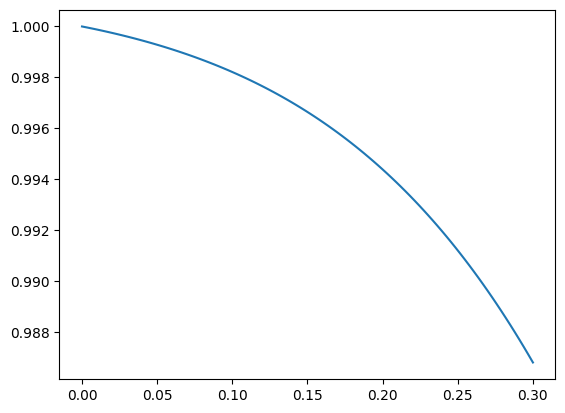

In [76]:
plt.clf()
plt.plot(w,a)
display(plt.gcf())

In [92]:
PEGMw = 200
model = pharmaPCSAFT(["water08","PEG200"])

model.params.Mw[2] = PEGMw
model.params.segment[2] = model.params.segment[2]/200*PEGMw
Mw = model.params.Mw.values

2-element Vector{Float64}:
  18.015
 200.0

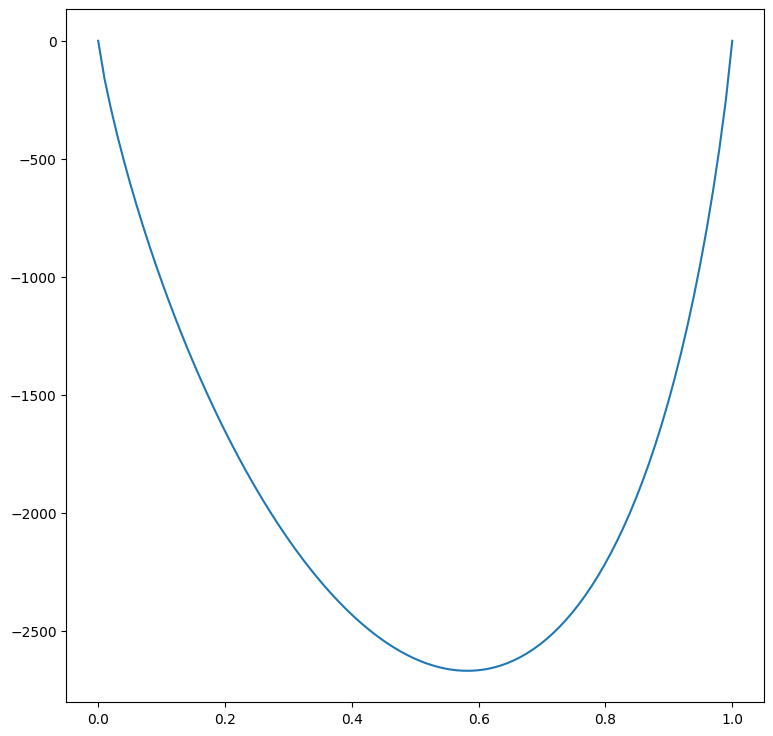

In [94]:
x = LinRange(0,1,100)
X = Clapeyron.FractionVector.(x)
p = 1e5
T = 298.15

g = mixing.(model,p,T,X,gibbs_free_energy)

plt.clf()
plt.plot(x,g)
display(plt.gcf())

In [28]:
model = sCPA(["water"];
        userlocations=(;
        Mw = [18.],
        b = [0.0145],
        a = [1018.3336*8.314*0.0145*1e-3/1e-1],
        c1 = [0.6736],
        n_H = [2],
        n_e = [2],
        epsilon_assoc = Dict((("water","H"),("water","e"))=>2003.1361*8.314/1e2),
        bondvol = Dict((("water","H"),("water","e"))=>69.2),
        Tc = [647.096],
        Pc = [1e6]),
        alpha_userlocations=(;
        Tc = [647.096],
        c1 = [0.6736]))

sCPA{BasicIdeal, RK{BasicIdeal, Clapeyron.sCPAAlpha, NoTranslation, vdW1fRule}} with 1 component:
 "water"
Contains parameters: a, b, c1, Tc, epsilon_assoc, bondvol, Mw

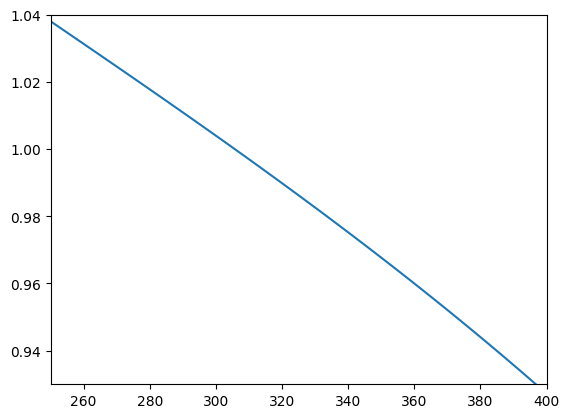

In [29]:
p = 1e5
T = LinRange(250,400,100)
ρ = mass_density.(model,p,T;phase=:l)

plt.clf()
plt.plot(T,ρ./1e3)
plt.xlim(250,400)
plt.ylim(0.93,1.04)
display(plt.gcf())